In [1]:
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Welcome to JupyROOT 6.26/08


In [2]:
tagger_name = "LundNet"

#Load tagger losses
loss_df = pd.read_csv('losses_LundNet_weighted_0404-1802.txt')
loss_df

Train_Loss  Val_Loss  Train_jds  Val_jds  Train_bgrej  Val_bgrej
0     0.545090  0.488568          0        0            0          0
1     0.435539  0.428808          0        0            0          0
2     0.417965  0.429487          0        0            0          0
3     0.413448  0.426818          0        0            0          0
4     0.411039  0.421516          0        0            0          0
5     0.410130  0.407694          0        0            0          0
6     0.410937  0.412042          0        0            0          0
7     0.407704  0.438528          0        0            0          0
8     0.407708  0.416772          0        0            0          0
9     0.406002  0.409414          0        0            0          0
10    0.402180  0.417451          0        0            0          0
11    0.403795  0.406130          0        0            0          0
12    0.399451  0.404521          0        0            0          0
13    0.400024  0.406983          0        0            0          0
14    0.399758  0.421755          0        0            0          0
15    0.397855  0.426123          0        0            0          0
16    0.398366  0.410880          0        0            0          0
17    0.397387  0.407872          0        0            0          0
18    0.396134  0.404519          0        0            0          0
19    0.392085  0.401781          0        0            0          0
20    0.393019  0.404695          0        0            0          0
21    0.392402  0.409991          0        0            0          0
22    0.390886  0.403873          0        0            0          0
23    0.389495  0.410388          0        0            0          0
24    0.391491  0.409170          0        0            0          0
25    0.390751  0.404152          0        0            0          0
26    0.390307  0.404023          0        0            0          0
27    0.386421  0.405514          0        0            0          0
28    0.386968  0.427009          0        0            0          0
29    0.388341  0.412292          0        0            0          0

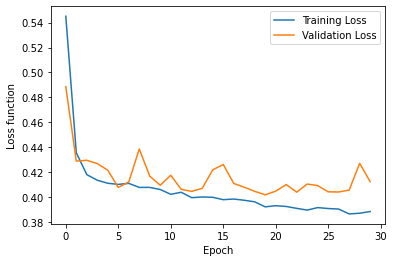

In [3]:
plt.plot( loss_df['Train_Loss'], label="Training Loss" )
plt.plot( loss_df['Val_Loss'], label="Validation Loss" )
plt.xlabel( "Epoch" )
plt.ylabel( "Loss function" )
plt.legend()

In [4]:
# tagger_scores = "test_ntuples/combined_oldmass_test.root_score_Lundnet_oldmass_v01.root"
tagger_scores = "combined_drbosons_oldmass_test.root_score_LundNetScores.root"
f = rt.TFile(tagger_scores)
t = f.Get("FlatSubstructureJetTree")

In [5]:
rdf = rt.RDataFrame( t )
test_dict = rdf.AsNumpy()

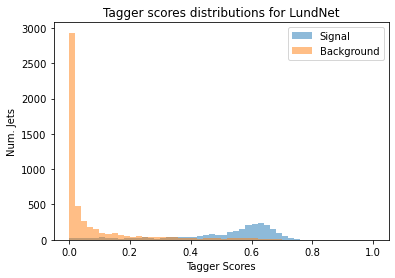

In [6]:
kwargs = {
    "bins": 50,
    "range": [0, 1.0],
    "alpha": 0.5,
    "density": False,
}
#(( dsids < 1 ) | (dsids > 370000)) & ( dr_w_boson < 0.1 )

is_signal = ((test_dict['EventInfo_mcChannelNumber'] < 1)|(test_dict['EventInfo_mcChannelNumber'] > 370000)) & (test_dict['fdr_w_boson'] < 0.1) & (test_dict["fdr_z_boson"] > 1.0 )
# is_signal = test_dict['EventInfo_mcChannelNumber'] > 370000
is_bg= ((test_dict['EventInfo_mcChannelNumber'] > 1)|(test_dict['EventInfo_mcChannelNumber'] < 370000)) & (test_dict['fdr_w_boson'] > 0.1) & (test_dict["fdr_z_boson"] > 1.0 )
#(~is_signal) & (test_dict["fdr_z_boson"] > 1.0)

hist_sig = plt.hist( test_dict['fjet_nnscore'][ is_signal ], label="Signal", **kwargs )
hist_bkg = plt.hist( test_dict['fjet_nnscore'][ is_bg ], label="Background", **kwargs )
plt.title(f"Tagger scores distributions for {tagger_name}")
plt.xlabel("Tagger Scores")
plt.ylabel("Num. Jets")
plt.legend(loc='upper right')

[0.56475466 0.43249536 0.66842926 ... 0.57352346 0.46022594 0.11020973]


(array([127., 117., 120., 180., 294., 630., 951., 135.,  12.,  11.]),
 ndarray([5.6450517e-04, 9.9234581e-02, 1.9790465e-01, 2.9657471e-01,
          3.9524481e-01, 4.9391487e-01, 5.9258497e-01, 6.9125503e-01,
          7.8992510e-01, 8.8859516e-01, 9.8726523e-01], dtype=float32),
 <BarContainer object of 10 artists>)

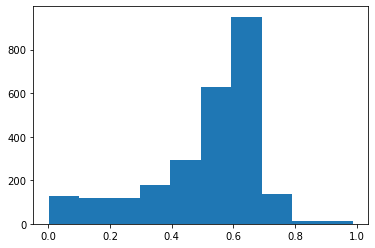

In [7]:
np.sum(test_dict['EventInfo_mcChannelNumber']==0)
print (test_dict['fjet_nnscore'][ is_signal ])
plt.hist(test_dict['fjet_nnscore'][ is_signal ])

In [8]:
def roc_from_numpy_hist( arr_sig, arr_bkg ):
    """
    Makes a ROC curve from arrays containing histogram bins of signal and background scores.
    """
    tprs = np.array([ np.sum(arr_sig[i:]) / np.sum(arr_sig) for i in range(len(arr_sig)) ])
    fprs = np.array([ np.sum(arr_bkg[i:]) / np.sum(arr_bkg) for i in range(len(arr_bkg)) ])

    auc = - np.trapz( tprs, fprs )
    
    return tprs, fprs, auc

Text(0.5, 0, 'False Positive Rate')

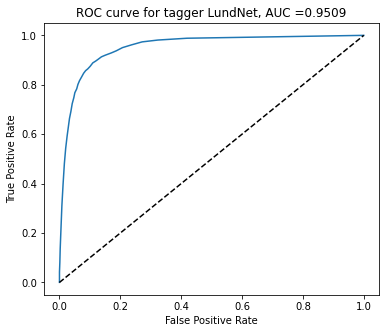

In [9]:
tprs, fprs, auc = roc_from_numpy_hist( hist_sig[0], hist_bkg[0] )

plt.figure(figsize=(6,5))
plt.plot(fprs, tprs)
plt.plot( [0,1],[0,1],'k--' )
plt.title( f"ROC curve for tagger {tagger_name}, AUC ={auc:.4f}" )
plt.ylabel( "True Positive Rate" )
plt.xlabel( "False Positive Rate" )

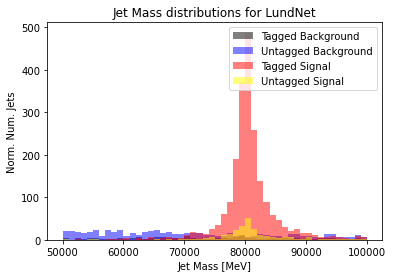

In [19]:
#This selection determines which events we classify as signal. 
#Cut may be change to optimise eg. highest possible TPR for low FPR.
nnscore_cut = 0.3
tag_signal = test_dict['fjet_nnscore'] > nnscore_cut

#Plot tagged/untagged signal and background mass distributions
kwargs = {
    "bins": 50,
    "range": [50e3, 100e3],
    "alpha": 0.5,
    "density": False,
}

hist_m_bkg_tag = plt.hist( test_dict['fjet_m'][ is_bg & tag_signal ], label="Tagged Background",color ="black", **kwargs )
hist_m_bkg_untag = plt.hist( test_dict['fjet_m'][ is_bg & ~tag_signal ], label="Untagged Background",color ="blue", **kwargs )
hist_m_sig_tag = plt.hist( test_dict['fjet_m'][ is_signal & tag_signal ], label="Tagged Signal",color ="red", **kwargs )
hist_m_sig_untag = plt.hist( test_dict['fjet_m'][ is_signal & ~tag_signal ], label="Untagged Signal", color ="yellow",**kwargs )

plt.title(f"Jet Mass distributions for {tagger_name}")
plt.xlabel("Jet Mass [MeV]")
plt.ylabel("Norm. Num. Jets")
plt.legend(loc='upper right')

In [20]:
bincs_m = 0.5 * ( hist_m_sig_tag[1][1:] + hist_m_sig_tag[1][:-1] )

sig_eff_m = hist_m_sig_tag[0] / ( hist_m_sig_tag[0] + hist_m_sig_untag[0] )
bkg_eff_m = hist_m_bkg_untag[0] / ( hist_m_bkg_tag[0] + hist_m_bkg_untag[0] )

/tmp/ipykernel_537/1091293238.py:3: RuntimeWarning: invalid value encountered in true_divide
  sig_eff_m = hist_m_sig_tag[0] / ( hist_m_sig_tag[0] + hist_m_sig_untag[0] )


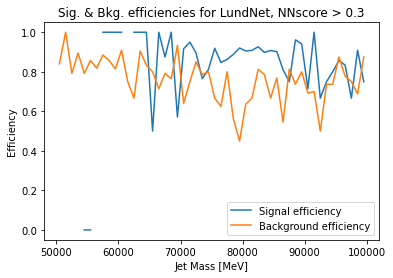

In [21]:
plt.plot( bincs_m, sig_eff_m, label="Signal efficiency" )
plt.plot( bincs_m, bkg_eff_m, label="Background efficiency" )

plt.title(f"Sig. & Bkg. efficiencies for {tagger_name}, NNscore > {nnscore_cut}")
plt.xlabel("Jet Mass [MeV]")
plt.ylabel("Efficiency")
plt.legend(loc='lower right')

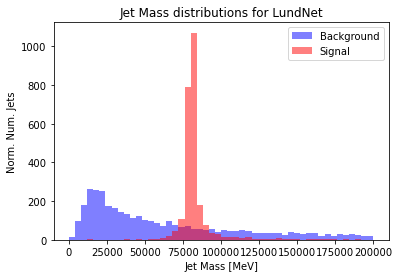

In [23]:
#Plot tagged/untagged signal and background mass distributions # 50
kwargs = {
    "bins": 50,
    "range": [0, 200e3],
    "alpha": 0.5,
    "density": False,
}

hist_m_bkg = plt.hist( test_dict['fjet_m'][ is_bg ], label="Background",color ="blue", **kwargs )
hist_m_sig_tag = plt.hist( test_dict['fjet_m'][ is_signal ], label="Signal",color ="red", **kwargs )


plt.title(f"Jet Mass distributions for {tagger_name}")
plt.xlabel("Jet Mass [MeV]")
plt.ylabel("Norm. Num. Jets")
plt.legend(loc='upper right')